# Lession 1:

> FastAI course lesson one

In [ ]:
#| default_exp Intro

## Check for all installs and versions

In [ ]:
!conda list | grep "pytorch"

ffmpeg                    4.3                  hf484d3e_0    pytorch
libjpeg-turbo             2.0.0                h9bf148f_0    pytorch
pytorch                   2.0.1           py3.11_cuda11.8_cudnn8.7.0_0    pytorch
pytorch-cuda              11.8                 h7e8668a_5    pytorch
pytorch-ignite            0.4.12                   pypi_0    pypi
pytorch-lightning         2.0.5                    pypi_0    pypi
pytorch-mutex             1.0                        cuda    pytorch
torchaudio                2.0.2               py311_cu118    pytorch
torchtriton               2.0.0                     py311    pytorch
torchvision               0.15.2              py311_cu118    pytorch


In [ ]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [ ]:
!pip list | grep "fastai" 

/bin/bash: line 1: findstr: command not found
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
!pip list | grep "duckduckgo"

/bin/bash: line 1: findstr: command not found
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
!pip list | grep "fastbook"

/bin/bash: line 1: findstr: command not found
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

## Generate Data Images

In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *
import os

In [ ]:
#|exports
#|code-fold: true
def download_pic(name):   
    # File path of the image
    image_path = f'{name}.jpg'

    # Check if the image file exists
    if os.path.exists(image_path):
        print("Image file exists.")
    else:
        print("Image file does not exist.")
        download_url(
            search_images_ddg(f'{name}',
            max_images=1)[0], f'{name}.jpg',
            show_progress=False
        )

    return Image.open(f'{name}.jpg').to_thumb(256,256)

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

Image file exists.


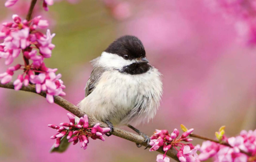

In [ ]:
#|eval: false
download_pic('bird')

...and then download a URL and take a look at it:

Now let's do the same with "forest photos":

Image file exists.


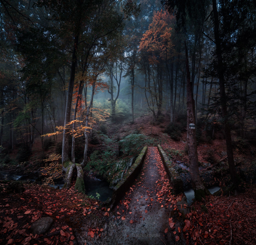

In [ ]:
#|eval: false
download_pic('forest')

In [ ]:
#|exports
#|code-fold: true
def create_searches_folder(folder_path, searches):
    for i in searches:
        dest = (folder_path/i)
        dest.mkdir(exist_ok=True, parents=True)
        print(f'created {i} folder')

In [ ]:
#|exports
#|code-fold: true
def download_search_images(folder_path, searches, amount):
    for j in searches:
        print(f"downloading images for: {j}")
        download_images(
            folder_path/j,
            urls=search_images_ddg(f'{j} photo', amount),
            n_workers=16
        )

In [ ]:
#|exports
#|code-fold: true
def verify_pics(folder_path):
    failed = verify_images(get_image_files(folder_path))
    failed.map(Path.unlink)
    print(f"Number of images failed: {len(failed)}")

In [ ]:
#|exports
#|code-fold: true
def resize_pics(folder_path, searches):
    for k in searches:
        resize_images(
            folder_path/k,
            max_size=400,
            dest=folder_path/k,
            max_workers=8
        )
        print(f"resizing images for: {k}")

In [ ]:
#|exports
#|code-fold: true
def create_data_folder(folder_path, searches, amount):
    if os.path.exists(folder_path):
        print(f"Folder already exists: {folder_path}")
    else:   
        create_searches_folder(folder_path, searches)
        download_search_images(folder_path, searches, amount)
        verify_pics(folder_path)
        resize_pics(folder_path, searches)

        

In [ ]:
#|code-fold: true
searches = 'forest','bird'
path = Path('bird_or_not')

create_data_folder(path, searches, 200)

Folder already exists: bird_or_not


## Creating the model

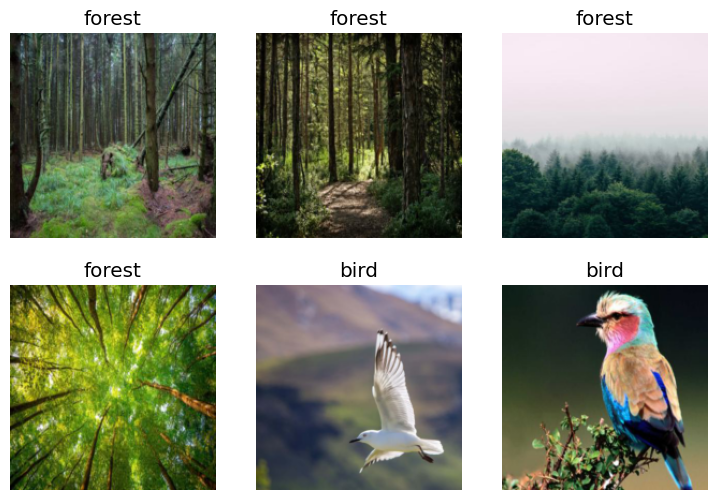

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 
    
To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

## Traning the model
Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.1

In [ ]:
#|eval: false
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/ben/mambaforge/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/mambaforge/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.745864,0.485671,0.156250,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.026243,0.026303,0.015625,00:03
1,0.014560,0.000682,0.000000,00:02
2,0.009399,0.001806,0.000000,00:02


## Step 3: Use our model (and build your own!)
Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
#|eval: false
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


## Deep Learning Is Not Just for Image Classification

  - SegmentationDataLoaders - Easier than datablocks 
  
```python
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

```

- Tabular analysis - income prediction

```python
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3)

dls.show_batch()

```



- Collaboration filtering - ratings/ recommendations

```python
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)
learn.show_results()
```


- Example
```python
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)
```

This reduces the batch size to 32 (we will explain this later). If you keep hitting the same error, change 32 to 16

- Example
```python
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy)
learn.fine_tune(4, 1e-2)
```